In [1]:
from scipy.io import netcdf
import numpy
from davitpy.pydarn.radar import *
from davitpy.pydarn.plotting import *
from davitpy.utils import *
import netCDF4
import cdf
import pandas
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot', 'pylab', 'figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
inpFN18 = "/home/bharat/Documents/code/auroral-imager/data/processed/F18/20141216.txt"
inpFN17 = "/home/bharat/Documents/code/auroral-imager/data/processed/F17/20141216.txt"
inpTime = datetime.datetime(2014,12,16,11,30)

In [3]:
ssusiDF = pandas.read_csv( inpFN18, delim_whitespace=True,\
                                infer_datetime_format=True,\
                                parse_dates=["date"] )
# ssusiDF17 = pandas.read_csv( inpFN17, delim_whitespace=True,\
#                                 infer_datetime_format=True,\
#                                 parse_dates=["date"] )
# ssusiDF = pandas.concat( [ssusiDF18, ssusiDF17] )

In [4]:
# get min and max times in each orbit
orbitMin = ssusiDF[ ["date", "sat", "orbitNum"] ].groupby(["orbitNum", "sat"]).min().reset_index()
orbitMin.columns = [ "orbitNum", "sat", "date_min" ]
orbitMax = ssusiDF[ ["date", "sat", "orbitNum"] ].groupby(["orbitNum", "sat"]).max().reset_index()
orbitMax.columns = [ "orbitNum", "sat", "date_max" ]
orbitDF = pandas.merge( orbitMin, orbitMax, on=["orbitNum", "sat"] )
# get orbit corresponding to selected input time
selOrbit = orbitDF[ (orbitDF["date_min"] <= inpTime) &\
                 (orbitDF["date_max"] >= inpTime)\
                  ].reset_index(drop=True)
print selOrbit

   orbitNum  sat                   date_min                   date_max
0     26612  F18 2014-12-16 11:10:41.000331 2014-12-16 12:52:36.000048


In [5]:
# Now merge the two DFs to only select data
# from the orbit of interest
ssusiDF = ssusiDF.merge( selOrbit, on=[ "orbitNum", "sat" ] )
ssusiDF.head()

,date,sat,orbitNum,glat.1,glat.2,glat.3,glat.4,glat.5,glat.6,glat.7,...,dlbhl.35,dlbhl.36,dlbhl.37,dlbhl.38,dlbhl.39,dlbhl.40,dlbhl.41,dlbhl.42,date_min,date_max
0,2014-12-16 11:10:41.000331,F18,26612,46.18,46.27,46.30,46.30,46.29,46.26,46.24,...,-2.97,-1.99,-3.44,NaN,NaN,NaN,NaN,NaN,2014-12-16 11:10:41.000331,2014-12-16 12:52:36.000048
1,2014-12-16 11:10:45.000080,F18,26612,46.39,46.48,46.51,46.51,46.50,46.48,46.45,...,-5.21,-3.17,-3.44,NaN,NaN,NaN,NaN,NaN,2014-12-16 11:10:41.000331,2014-12-16 12:52:36.000048
2,2014-12-16 11:10:48.000829,F18,26612,46.60,46.69,46.73,46.73,46.72,46.70,46.67,...,-1.10,0.00,126.87,NaN,NaN,NaN,NaN,NaN,2014-12-16 11:10:41.000331,2014-12-16 12:52:36.000048
3,2014-12-16 11:10:52.000578,F18,26612,46.81,46.91,46.94,46.95,46.94,46.91,46.89,...,-1.93,81.37,-2.43,NaN,NaN,NaN,NaN,NaN,2014-12-16 11:10:41.000331,2014-12-16 12:52:36.000048
4,2014-12-16 11:10:56.000327,F18,26612,47.02,47.12,47.16,47.16,47.15,47.13,47.10,...,70.82,-0.50,-2.00,NaN,NaN,NaN,NaN,NaN,2014-12-16 11:10:41.000331,2014-12-16 12:52:36.000048


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


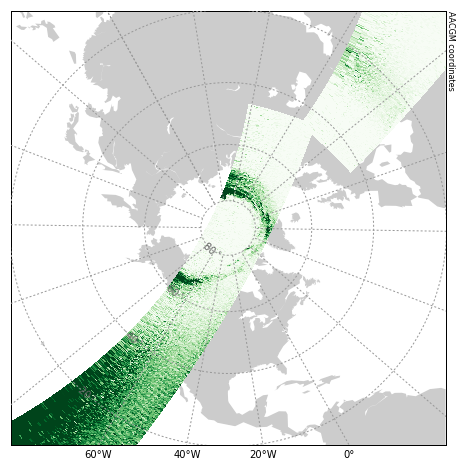

In [6]:
ssusiMlats18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('glat')\
                ]].values
ssusiMlons18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('glon')\
                ]].values
ssusiDisk18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('d135')\
                ]].values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
m = plotUtils.mapObj(boundinglat=10., coords='mag')

p = m.pcolormesh(ssusiMlons18, ssusiMlats18, ssusiDisk18, latlon=True, zorder=1.9,
                        vmin=0, vmax=1000,
                        ax=ax, alpha=1, cmap='Greens')

p.set_rasterized(True)

fig.savefig("../figs/ssusi-test.pdf",bbox_inches='tight')

In [7]:
print ssusiMlons18[315,:]

[ 283.83  287.88  290.97  293.06  295.15  297.26  298.84  299.89  300.94
  301.99  303.04  304.09  305.13  306.17  307.21  308.24  309.27  310.29
  311.3   312.31  313.31  314.3   315.29  316.26  317.23  318.19  319.14
  320.08  321.01  321.94  322.85  323.75  324.64  325.52  326.39  327.24
  328.09  328.93  329.75  330.57  331.37  332.16]
